# Объяснение

У нас три вида экспериментов (cls, avg, token)

На каждый 3 запуска для каждой модели (seed 100, 200, 300)

У каждого экземпляра есть аттрибут 'predicted' на каждую категорию 

Пример
[(0, 'Acc', 'Acc'),
 (1, 'Ins', 'Ins'),
 (2, 'Nom', 'Nom'),
 (3, 'Acc', 'Nom'),
 (4, 'Gen', 'Gen'),
 (5, 'Gen', 'Gen'),
 (6, 'Acc', 'Acc'),
 (7, 'Ins', 'Ins'),
 (8, 'Gen', 'Gen'),
 (9, 'Acc', 'Acc')]

- Первое число ничего не значит, просто номер

- Второе - предсказали

- Третье - True метрика

Для cls и усредненного эмбеддинга пробинг по предложению, потокенный отфильтрован так, что там только не None

Чтобы понять, к какому предложению относится предсказание для cls и avg, надо прочитать файл с предложениями для категории и обрезать от 2000 примера и дальше. Пример как - ниже.

Для потокенного токены отдельно сохранены, но сами токены по nan'ам не отфильтрованы. Пример ниже.

In [112]:
# !pip install plotly statsmodels scikit-learn seaborn

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
import sys
package_paths = ['visualisations']
for pth in package_paths:
    sys.path.append(pth)

In [4]:
from initialize import Init

In [5]:
from utils import accuracy_lines, large_vi, mine, common_neurons_percentage_multiple, plot_distr, \
                      accuracy_dif, accuracy_dif_control, accuracy_dif2

In [29]:
from statsmodels.stats.contingency_tables import mcnemar 

In [99]:
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
CATS = ['ADJ_Gender', 'ADJ_Number',  'NOUN_Number', 'NOUN_Gender', 'NOUN_Case', 'VERB_Aspect', 'VERB_Tense']

In [15]:
path_1 = 'good_cls100/'
good_cls = Init(path_1, 'ru')
path_2 = 'good_avg200/'
good_avg = Init(path_2, 'ru')
path_3 = 'good_token300/'
good_token = Init(path_3, 'ru')
path_11 = 'broken_cls100/'
broken_cls = Init(path_11, 'ru')
path_22 = 'broken_avg200/'
broken_avg = Init(path_22, 'ru')
path_33 = 'broken_token300/'
broken_token = Init(path_33, 'ru')

In [8]:
data_path = 'data/per_sent/ru_rusenteval_NOUN_Case.txt'

In [9]:
with open(data_path, encoding="utf-8") as f:
    noun_case = [line.split('\t') for line in f]

In [10]:
import re
all_sents = []
all_values = []
for idx, line in enumerate(noun_case):
    if idx % 2 == 0:
        line = re.sub('  ', ' ', line[0])
        all_sents.append(line)
    else:
        line = line[0].replace("\'", "").replace(",", "")
        all_values.append(line)

sents_test = all_sents[2000:]
values_test = all_values[2000:]

In [11]:
sents_test[:10]

['Но мы также готовы рассматривать и другие кандидатуры\n',
 'Он должен руководить театром самостоятельно\n',
 'Преступники смогли унести одну из них\n',
 'Кроме того хранить не будут транзитный трафик\n',
 'Имеет два высших военных образования\n',
 'Однако никаких подробностей раскрывать не стали\n',
 'Выставлять дополнительные посты запрещается\n',
 'Владеет английским персидским азербайджанским турецким и русским языками\n',
 'Имеет несколько высших образований\n',
 'И не каждый может выдержать такой экзамен\n']

In [12]:
values_test[:10]

['Acc\n',
 'Ins\n',
 'Nom\n',
 'Nom\n',
 'Gen\n',
 'Gen\n',
 'Acc\n',
 'Ins\n',
 'Gen\n',
 'Acc\n']

In [16]:
good_cls.predicted['NOUN_Case'][:10]

[(0, 'Acc', 'Acc'),
 (1, 'Ins', 'Ins'),
 (2, 'Nom', 'Nom'),
 (3, 'Acc', 'Nom'),
 (4, 'Gen', 'Gen'),
 (5, 'Gen', 'Gen'),
 (6, 'Acc', 'Acc'),
 (7, 'Ins', 'Ins'),
 (8, 'Gen', 'Gen'),
 (9, 'Acc', 'Acc')]

In [17]:
broken_cls.predicted['NOUN_Case'][:10]

[(0, 'Acc', 'Acc'),
 (1, 'Ins', 'Ins'),
 (2, 'Acc', 'Nom'),
 (3, 'Acc', 'Nom'),
 (4, 'Gen', 'Gen'),
 (5, 'Gen', 'Gen'),
 (6, 'Acc', 'Acc'),
 (7, 'Ins', 'Ins'),
 (8, 'Gen', 'Gen'),
 (9, 'Acc', 'Acc')]

In [14]:
good_avg.predicted['NOUN_Case'][:10]

[(0, 'Acc', 'Acc'),
 (1, 'Ins', 'Ins'),
 (2, 'Acc', 'Nom'),
 (3, 'Nom', 'Nom'),
 (4, 'Gen', 'Gen'),
 (5, 'Gen', 'Gen'),
 (6, 'Acc', 'Acc'),
 (7, 'Ins', 'Ins'),
 (8, 'Gen', 'Gen'),
 (9, 'Acc', 'Acc')]

In [36]:
print(len(good_avg.predicted['NOUN_Case']), len(good_token.predicted['NOUN_Case']))

1000 3493


In [14]:
with open('good_token300/tokens_ru_taiga.pkl', 'rb') as f:
    tokens = pickle.load(f)

In [15]:
tokens['NOUN_Case']['source'][0]

['Занимается', 'станковой', 'живописью', 'и', 'книжной', 'графикой']

In [16]:
tokens['NOUN_Case']['target'][0]

['None', 'None', 'Ins', 'None', 'None', 'Ins']

In [17]:
good_token.predicted['NOUN_Case'][:10]

[(0, 'Ins', 'Ins'),
 (1, 'Ins', 'Ins'),
 (2, 'Nom', 'Nom'),
 (3, 'Acc', 'Acc'),
 (4, 'Nom', 'Nom'),
 (5, 'Ins', 'Ins'),
 (6, 'Nom', 'Nom'),
 (7, 'Ins', 'Ins'),
 (8, 'Nom', 'Dat'),
 (9, 'Ins', 'Ins')]

In [18]:
good_token.predicted['VERB_Tense'][:10]

[(0, 'Pres', 'Pres'),
 (1, 'Pres', 'Pres'),
 (2, 'Pres', 'Pres'),
 (3, 'Past', 'Past'),
 (4, 'Pres', 'Pres'),
 (5, 'Past', 'Past'),
 (6, 'Pres', 'Pres'),
 (7, 'Past', 'Past'),
 (8, 'Pres', 'Pres'),
 (9, 'Pres', 'Pres')]

In [23]:
counts = 0
for tpl in good_token.predicted['VERB_Tense']:
    if tpl[2] == 'Past':
        counts+=1
counts

486

### McNemar's test for classifier comparisons
chi-squared test for paired nominal data with continuity correction

In [113]:
tt_score = 0
tf_score = 0
ft_score = 0
ff_score = 0
for CAT in CATS:
    print(CAT)
    for i in range(len(good_cls.predicted[CAT])):
        if good_cls.predicted[CAT][i][1]==good_cls.predicted[CAT][i][2] and broken_cls.predicted[CAT][i][1]==broken_cls.predicted[CAT][i][2]:
            tt_score+=1
        if good_cls.predicted[CAT][i][1]==good_cls.predicted[CAT][i][2] and broken_cls.predicted[CAT][i][1]!=broken_cls.predicted[CAT][i][2]:
            tf_score+=1
        if good_cls.predicted[CAT][i][1]!=good_cls.predicted[CAT][i][2] and broken_cls.predicted[CAT][i][1]==broken_cls.predicted[CAT][i][2]:
            ft_score+=1
        else:
            ff_score+=1
    
    data = [[tt_score, tf_score], 
            [ft_score, ff_score]] 
    print(data)
    print(mcnemar(data, exact=False))
    print()

ADJ_Gender
[[486, 270], [78, 922]]
pvalue      1.3304630664399899e-24
statistic   104.83045977011494

ADJ_Number
[[1221, 359], [132, 1868]]
pvalue      1.998357565702463e-24
statistic   104.0244399185336

NOUN_Number
[[2059, 416], [190, 2810]]
pvalue      6.245220505986964e-20
statistic   83.53960396039604

NOUN_Gender
[[2741, 517], [258, 3742]]
pvalue      1.903214452515575e-20
statistic   85.88903225806452

NOUN_Case
[[3481, 574], [340, 4660]]
pvalue      1.2885521108596321e-14
statistic   59.39715536105033

VERB_Aspect
[[4316, 635], [395, 5605]]
pvalue      9.551224411287181e-14
statistic   55.45728155339806

VERB_Tense
[[5245, 682], [407, 6593]]
pvalue      1.0148897701951853e-16
statistic   68.94031221303949



In [36]:
tt_score = 0
tf_score = 0
ft_score = 0
ff_score = 0
for CAT in CATS:
    print(CAT)
    for i in range(len(good_avg.predicted[CAT])):
        if good_avg.predicted[CAT][i][1]==good_avg.predicted[CAT][i][2] and broken_avg.predicted[CAT][i][1]==broken_avg.predicted[CAT][i][2]:
            tt_score+=1
        if good_avg.predicted[CAT][i][1]==good_avg.predicted[CAT][i][2] and broken_avg.predicted[CAT][i][1]!=broken_avg.predicted[CAT][i][2]:
            tf_score+=1
        if good_avg.predicted[CAT][i][1]!=good_avg.predicted[CAT][i][2] and broken_avg.predicted[CAT][i][1]==broken_avg.predicted[CAT][i][2]:
            ft_score+=1
        else:
            ff_score+=1
    
    data = [[tt_score, tf_score], 
            [ft_score, ff_score]] 
    print(data)
    print(mcnemar(data, exact=False))
    print()

ADJ_Gender
[[690, 151], [30, 970]]
pvalue      4.682722543272902e-19
statistic   79.55801104972376

ADJ_Number
[[1517, 193], [79, 1921]]
pvalue      7.301248537401902e-12
statistic   46.94485294117647

NOUN_Number
[[2413, 225], [103, 2897]]
pvalue      2.3714346260326408e-11
statistic   44.63719512195122

NOUN_Gender
[[3148, 326], [139, 3861]]
pvalue      6.3789005358471266e-18
statistic   74.4

NOUN_Case
[[3964, 389], [178, 4822]]
pvalue      1.1531019092085319e-18
statistic   77.77777777777777

VERB_Aspect
[[4831, 436], [217, 5783]]
pvalue      1.4508899687796388e-17
statistic   72.77794793261869

VERB_Tense
[[5790, 451], [229, 6771]]
pvalue      2.3515400719840436e-17
statistic   71.825



In [37]:
tt_score = 0
tf_score = 0
ft_score = 0
ff_score = 0
for CAT in CATS:
    print(CAT)
    for i in range(len(good_token.predicted[CAT])):
        if good_token.predicted[CAT][i][1]==good_token.predicted[CAT][i][2] and broken_token.predicted[CAT][i][1]==broken_token.predicted[CAT][i][2]:
            tt_score+=1
        if good_token.predicted[CAT][i][1]==good_token.predicted[CAT][i][2] and broken_token.predicted[CAT][i][1]!=broken_token.predicted[CAT][i][2]:
            tf_score+=1
        if good_token.predicted[CAT][i][1]!=good_token.predicted[CAT][i][2] and broken_token.predicted[CAT][i][1]==broken_token.predicted[CAT][i][2]:
            ft_score+=1
        else:
            ff_score+=1
    
    data = [[tt_score, tf_score], 
            [ft_score, ff_score]] 
    print(data)
    print(mcnemar(data, exact=False))
    print()

ADJ_Gender
[[1930, 277], [71, 2308]]
pvalue      4.309489326824862e-28
statistic   120.76149425287356

ADJ_Number
[[4369, 294], [76, 4767]]
pvalue      1.6234246969289903e-29
statistic   127.26756756756757

NOUN_Number
[[7419, 335], [121, 7888]]
pvalue      1.9681606728281378e-23
statistic   99.49342105263158

NOUN_Gender
[[10512, 709], [299, 11561]]
pvalue      5.663061458034515e-38
statistic   165.953373015873

NOUN_Case
[[13788, 784], [353, 15000]]
pvalue      3.0271527853223424e-37
statistic   162.62093227792437

VERB_Aspect
[[14759, 793], [366, 15987]]
pvalue      6.323648624560397e-36
statistic   156.57981018119068

VERB_Tense
[[15757, 793], [366, 16985]]
pvalue      6.323648624560397e-36
statistic   156.57981018119068



### Что с чем путается?

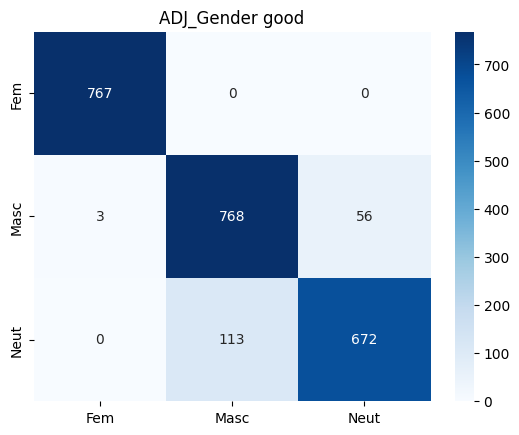

In [107]:
good_token_pred = list(np.array(good_token.predicted['ADJ_Gender'])[:, 1])
good_token_real = list(np.array(good_token.predicted['ADJ_Gender'])[:, 2])
data = confusion_matrix(good_token_real, good_token_pred, labels=["Fem", "Masc", "Neut"])
hm = sns.heatmap(data=data, yticklabels=["Fem", "Masc", "Neut"], xticklabels=["Fem", "Masc", "Neut"], annot=data, fmt="d", cmap="Blues")
plt.title('ADJ_Gender good')
plt.show() 

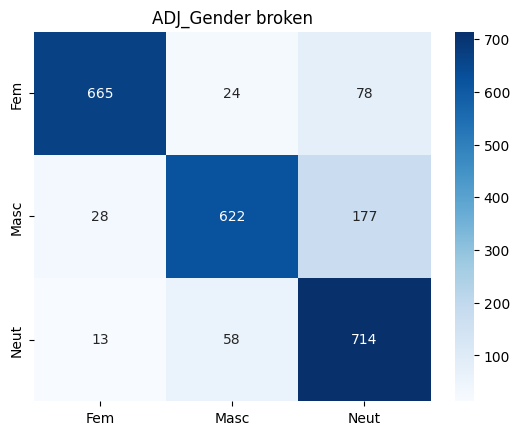

In [108]:
broken_token_pred = list(np.array(broken_token.predicted['ADJ_Gender'])[:, 1])
broken_token_real = list(np.array(broken_token.predicted['ADJ_Gender'])[:, 2])
data = confusion_matrix(broken_token_real, broken_token_pred, labels=["Fem", "Masc", "Neut"])

hm = sns.heatmap(data=data, yticklabels=["Fem", "Masc", "Neut"], xticklabels=["Fem", "Masc", "Neut"], annot=data, fmt="d", cmap="Blues")
plt.title('ADJ_Gender broken')
plt.show() 

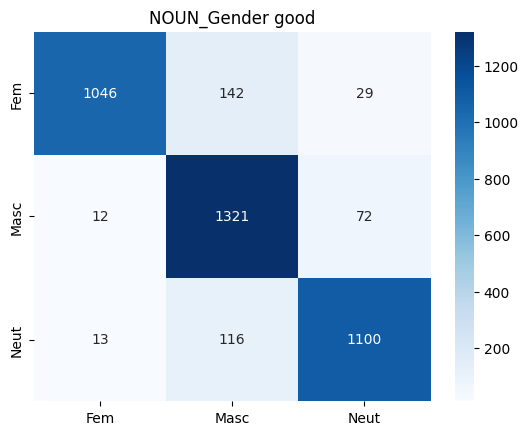

In [110]:
good_token_pred = list(np.array(good_token.predicted['NOUN_Gender'])[:, 1])
good_token_real = list(np.array(good_token.predicted['NOUN_Gender'])[:, 2])
data = confusion_matrix(good_token_real, good_token_pred, labels=["Fem", "Masc", "Neut"])
hm = sns.heatmap(data=data, yticklabels=["Fem", "Masc", "Neut"], xticklabels=["Fem", "Masc", "Neut"], annot=data, fmt="d", cmap="Blues")
plt.title('NOUN_Gender good')
plt.show() 

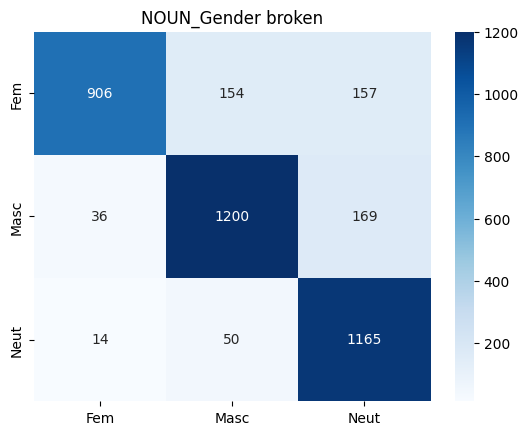

In [111]:
broken_token_pred = list(np.array(broken_token.predicted['NOUN_Gender'])[:, 1])
broken_token_real = list(np.array(broken_token.predicted['NOUN_Gender'])[:, 2])
data = confusion_matrix(broken_token_real, broken_token_pred, labels=["Fem", "Masc", "Neut"])

hm = sns.heatmap(data=data, yticklabels=["Fem", "Masc", "Neut"], xticklabels=["Fem", "Masc", "Neut"], annot=data, fmt="d", cmap="Blues")
plt.title('NOUN_Gender broken')
plt.show() 